In [1]:
import subprocess
import os

from transformers import AutoTokenizer

os.environ['HF_HOME'] = '/root/autodl-tmp/cache/'

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value


[Key‑Steering] pos‑only, layers [18, 19, 20, 21, 22, 23, 24, 25, 26, 27], γ+=1.5, γ‑=n/a, kernel=linear
✓ collected baseline and steered attentions


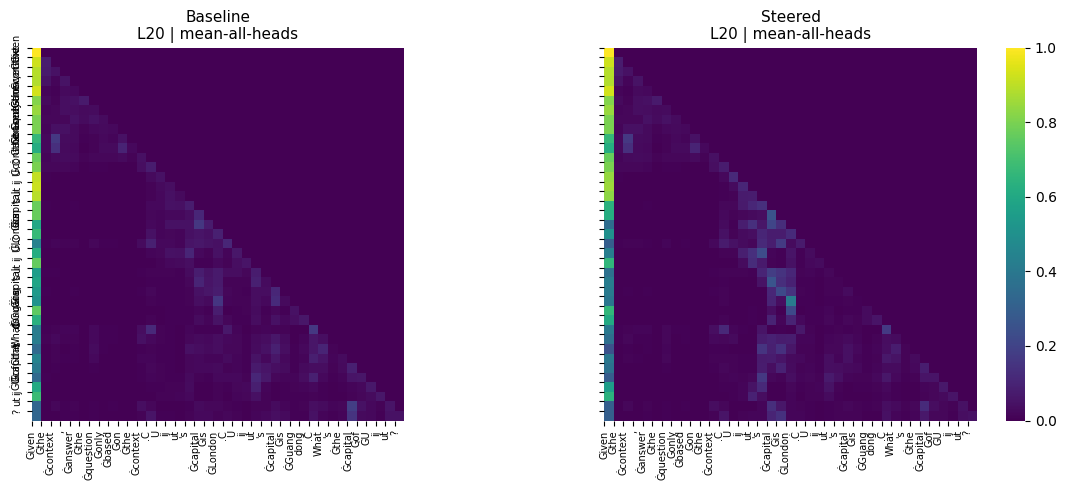

In [5]:
import torch, gc, seaborn as sns, matplotlib.pyplot as plt
import sys  
sys.path.insert(1, '../')
from src.model import SEKALLM                     # ← your new wrapper
from src.utils   import encode_with_markers            # unchanged

# ---------- 1. prompt -------------------------------------------------
prompt = (
    "Given the context, answer the question only based on the context.\n"
    "*Uijut's capital is London*.\n"
    "Uijut's capital is Guangdong.\n"
    "What's the capital of Uijut?"
)
tok      = AutoTokenizer.from_pretrained('../pretrained/qwen2-1.5b-chat')
ids, msk = encode_with_markers(prompt, tok)        # ids:(1,seq)  msk:(seq,)
ids      = ids.cuda();  device = ids.device

# ---------- 2. baseline forward --------------------------------------
ks = SEKALLM("../pretrained/qwen2-1.5b-chat", output_attentions=True)
with torch.no_grad():
    base_out  = ks.model(ids, output_attentions=True, use_cache=False)
base_attn = [l.detach().cpu() for l in base_out.attentions]

# ---------- 3. inject φ‑space K‑projection ---------------------------
ks.attach_projection(
    pos_pt="../projections/synthetic/qwen2-1.5b-chat_pos_proj.pt",
    layers="last10",
    mask_tensor=msk,
    amplify_pos=1.5,                # tune as needed
    # feature_function="squared-exponential"
)

with torch.no_grad():
    steer_out = ks.model(ids, output_attentions=True, use_cache=False)
steer_attn = [l.detach().cpu() for l in steer_out.attentions]

del ks, base_out, steer_out;  gc.collect()
print("✓ collected baseline and steered attentions")

# ---------- 4. visual helper -----------------------------------------
def show_pair(b_attn, s_attn, layer:int, head:int|None=None, vmax:float|None=None):
    B = b_attn[layer][0];  S = s_attn[layer][0]        # (H,T,T)

    if head is None:
        B = B.mean(0);  S = S.mean(0);  ttl = f"L{layer} | mean‑all‑heads"
    else:
        B = B[head];     S = S[head];    ttl = f"L{layer}, H{head}"

    vmax = float(max(B.max(), S.max())) if vmax is None else vmax
    tokens = tok.convert_ids_to_tokens(ids[0].tolist())

    fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    for i,(mat,title) in enumerate(zip([B,S],["Baseline","Steered"])):
        sns.heatmap(mat.numpy(), ax=ax[i], cmap="viridis",
                    vmin=0, vmax=vmax, cbar=i==1, square=True)
        ax[i].set_title(f"{title}\n{ttl}", fontsize=11)
        ax[i].set_xticks(range(len(tokens))); ax[i].set_xticklabels(tokens, rotation=90, fontsize=7)
        ax[i].set_yticks(range(len(tokens))); ax[i].set_yticklabels(tokens, fontsize=7)
    plt.tight_layout();  plt.show()

# ---------- 5. example ------------------------------------------------
show_pair(base_attn, steer_attn, layer=20, head=None)   # avg heads
# show_pair(base_attn, steer_attn, layer=20, head=3)    # one head
